In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.filters import frangi
import seaborn as sns


from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import gmean
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

In [28]:
size = (512, 512)
input_shape = [512, 512, 3]

In [ ]:
#wczytanie i wstępne przetworzenie obrazu
def read_and_process_image(image_path):
  
    img = cv2.imread(f'all/images/{image_path}.jpg')
    img = cv2.resize(img, size)

    #zostawiamy tylko zielony kanał
    green_channel = img[:, :, 1]

    #ograniczamy skrajne wartości pikseli
    green_channel = np.clip(green_channel, 10, 245)

    #CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(green_channel)

    return image


#wczytanie maski eksperckiej
def read_mask(image_name):

    mask = cv2.imread(f'all/manual1/{image_name}.tif', cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size)
    mask_norm = (mask > 127).astype(int)

    return mask_norm

TWORZENIE MACIERZY DANYCH

In [ ]:
def create_dataset_matrix(image, mask, patch_size=5):

    image_height, image_width = image.shape
    num_patches_x = image_width // patch_size
    num_patches_y = image_height // patch_size
    
    #Inicjalizacja macierzy (liczba patchy x (rozmiar patcha + etykieta))
    dataset_matrix = np.zeros((num_patches_x * num_patches_y, patch_size**2 + 1))
    
    for i in range(0, image_width, patch_size):
        for j in range(0, image_height, patch_size):
            
            #Pomijamy fragmenty wychodzące poza obraz
            if (i + patch_size > image_width) or (j + patch_size > image_height):
                continue
                
            #Wycinamy fragment
            patch = image[j:j+patch_size, i:i+patch_size]
            
            #Obliczamy indeks wiersza w macierzy
            row_idx = (i // patch_size) * num_patches_y + (j // patch_size)
            
            #Spłaszczamy fragment do 1D i dodaj do macierzy
            dataset_matrix[row_idx, :-1] = patch.flatten()
            
            #Pobieramy etykietę ze środka fragmentu
            center_y = j + patch_size // 2
            center_x = i + patch_size // 2
            dataset_matrix[row_idx, -1] = mask[center_y, center_x]
    
    return dataset_matrix


UCZENIE NA 10 OBRAZACH

In [31]:
#trenowanie na 10 obrazkach
image_names = ['01_g', '02_g', '03_g', '04_g', '05_g', '06_g', '07_g', '08_g', '09_g', '10_g']

processed_images = []
masks = []
for name in image_names:
    processed_img = read_and_process_image(name)
    mask = read_mask(name)
    processed_images.append(processed_img)
    masks.append(mask)
    
plt.figure(figsize=(20, 8))


<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

In [ ]:
#stworzenie macierzy danych (10 obrazków)
datasets = [create_dataset_matrix(processed_images[i], masks[i]) for i in range(10)]
dataset = np.vstack(datasets)

X = dataset[:, :-1] #cechy
y = dataset[:, -1]  #etykiety

#podział danych na dane treningowe i testowe - (podział warstwowy - stratified - taki sam rozkład klas)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

#Undersampling (tylko na zbiorze uczącym)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)


#tworzymy klasyfikator lasu losowego (Random Forest)
rfc = RandomForestClassifier(random_state=42)

#definicja pipeline 
pipeline = Pipeline([
    ('rfc', rfc)
])

#definiujemy hiperparametry
#liczba drzew -> Więcej drzew = większa dokładność, wolniejsze działanie
#max głebokość drzewa -> None - brak limitu, 20 - maksymalnie 20 poziomów w drzewie (głębsze drzewa mogą sie przeuczyć, zbyt płytkie - niedouczenie)
#minimalna liczba przykładów, jakie muszą znaleźć się w liściu 
#minimalna liczba przykładów, jaka musi być w węźle, żeby można było go podzielić

param_grid = {
    'rfc__n_estimators': [10, 100],
    'rfc__max_depth': [None, 20],
    'rfc__min_samples_leaf': [1, 2],
    'rfc__min_samples_split': [2, 5]
}

#testujemt wszystkie możliwe kombinacje hiperparametrów z siatki, wybieramy najlepszy
grid_search = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1, cv=5)

#Dopasowanie modelu do danych
grid_search.fit(X_train_balanced, y_train_balanced)

print("Najlepsze parametry:", grid_search.best_params_)


Najlepsze parametry: {'rfc__max_depth': None, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 100}


In [ ]:
# Po wytrenowaniu grid_search wykonaj predykcję na zbiorze testowym
y_pred = grid_search.best_estimator_.predict(X_test)
y_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # prawdopodobieństwa dla klasy 1

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

#podstawowe metryki
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Sensivity: {recall_score(y_test, y_pred):.3f}")
print(f"Specificity: {specificity}")

print('Training accuracy:', grid_search.score(X_train_balanced, y_train_balanced))
print('Test accuracy:', grid_search.score(X_test, y_test))

Accuracy: 0.949
Precision: 0.579
Sensivity: 0.838
Specificity: 0.9568688601278653
Training accuracy: 1.0
Test accuracy: 0.9490301159200792


PRZETWARZANIE OBRAZOW WYTRENOWANYM KLASYFIKATOREM

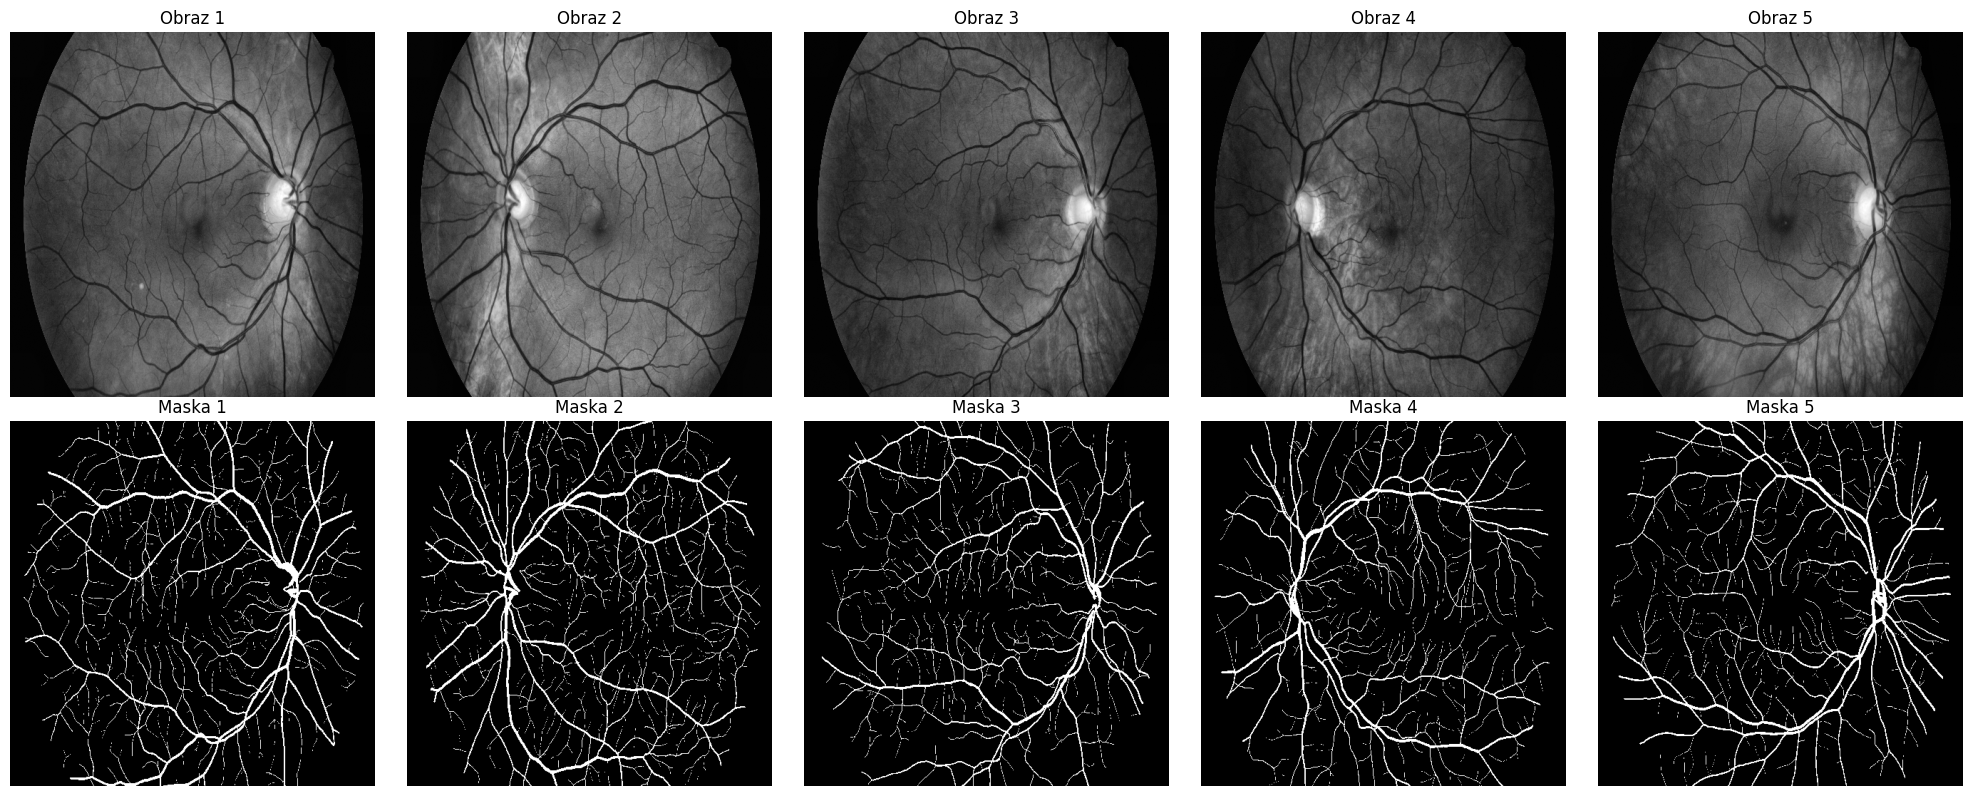

In [ ]:
image_names = ['11_g', '12_g', '13_g', '14_g', '15_g']

processed_images = []
masks = []
for name in image_names:
    processed_img = read_and_process_image(name)
    mask = read_mask(name)
    processed_images.append(processed_img)
    masks.append(mask)
    
plt.figure(figsize=(20, 8))

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(processed_images[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Obraz {i+1}')

for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Maska {i+1}')

plt.tight_layout()
plt.show()

In [ ]:

def show_parameters_from_masks(true_mask, predicted_mask):
    #spłaszczamy maski do 1D
    y_true = true_mask.flatten()
    y_pred = predicted_mask.flatten()
    
    #macierz pomyłek (TP, FP, FN, TN)
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    #metryki
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # czułość(recall)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    #średnia arytmetyczna i geometryczna z sensitivity i specificity
    mean_arithmetic = (sensitivity + specificity) / 2
    mean_geometric = gmean([sensitivity, specificity]) if sensitivity > 0 and specificity > 0 else 0

    return accuracy, sensitivity, specificity, mean_arithmetic, mean_geometric, cm


Przetwarzam obraz  0
Przetwarzam obraz  1
Przetwarzam obraz  2
Przetwarzam obraz  3
Przetwarzam obraz  4


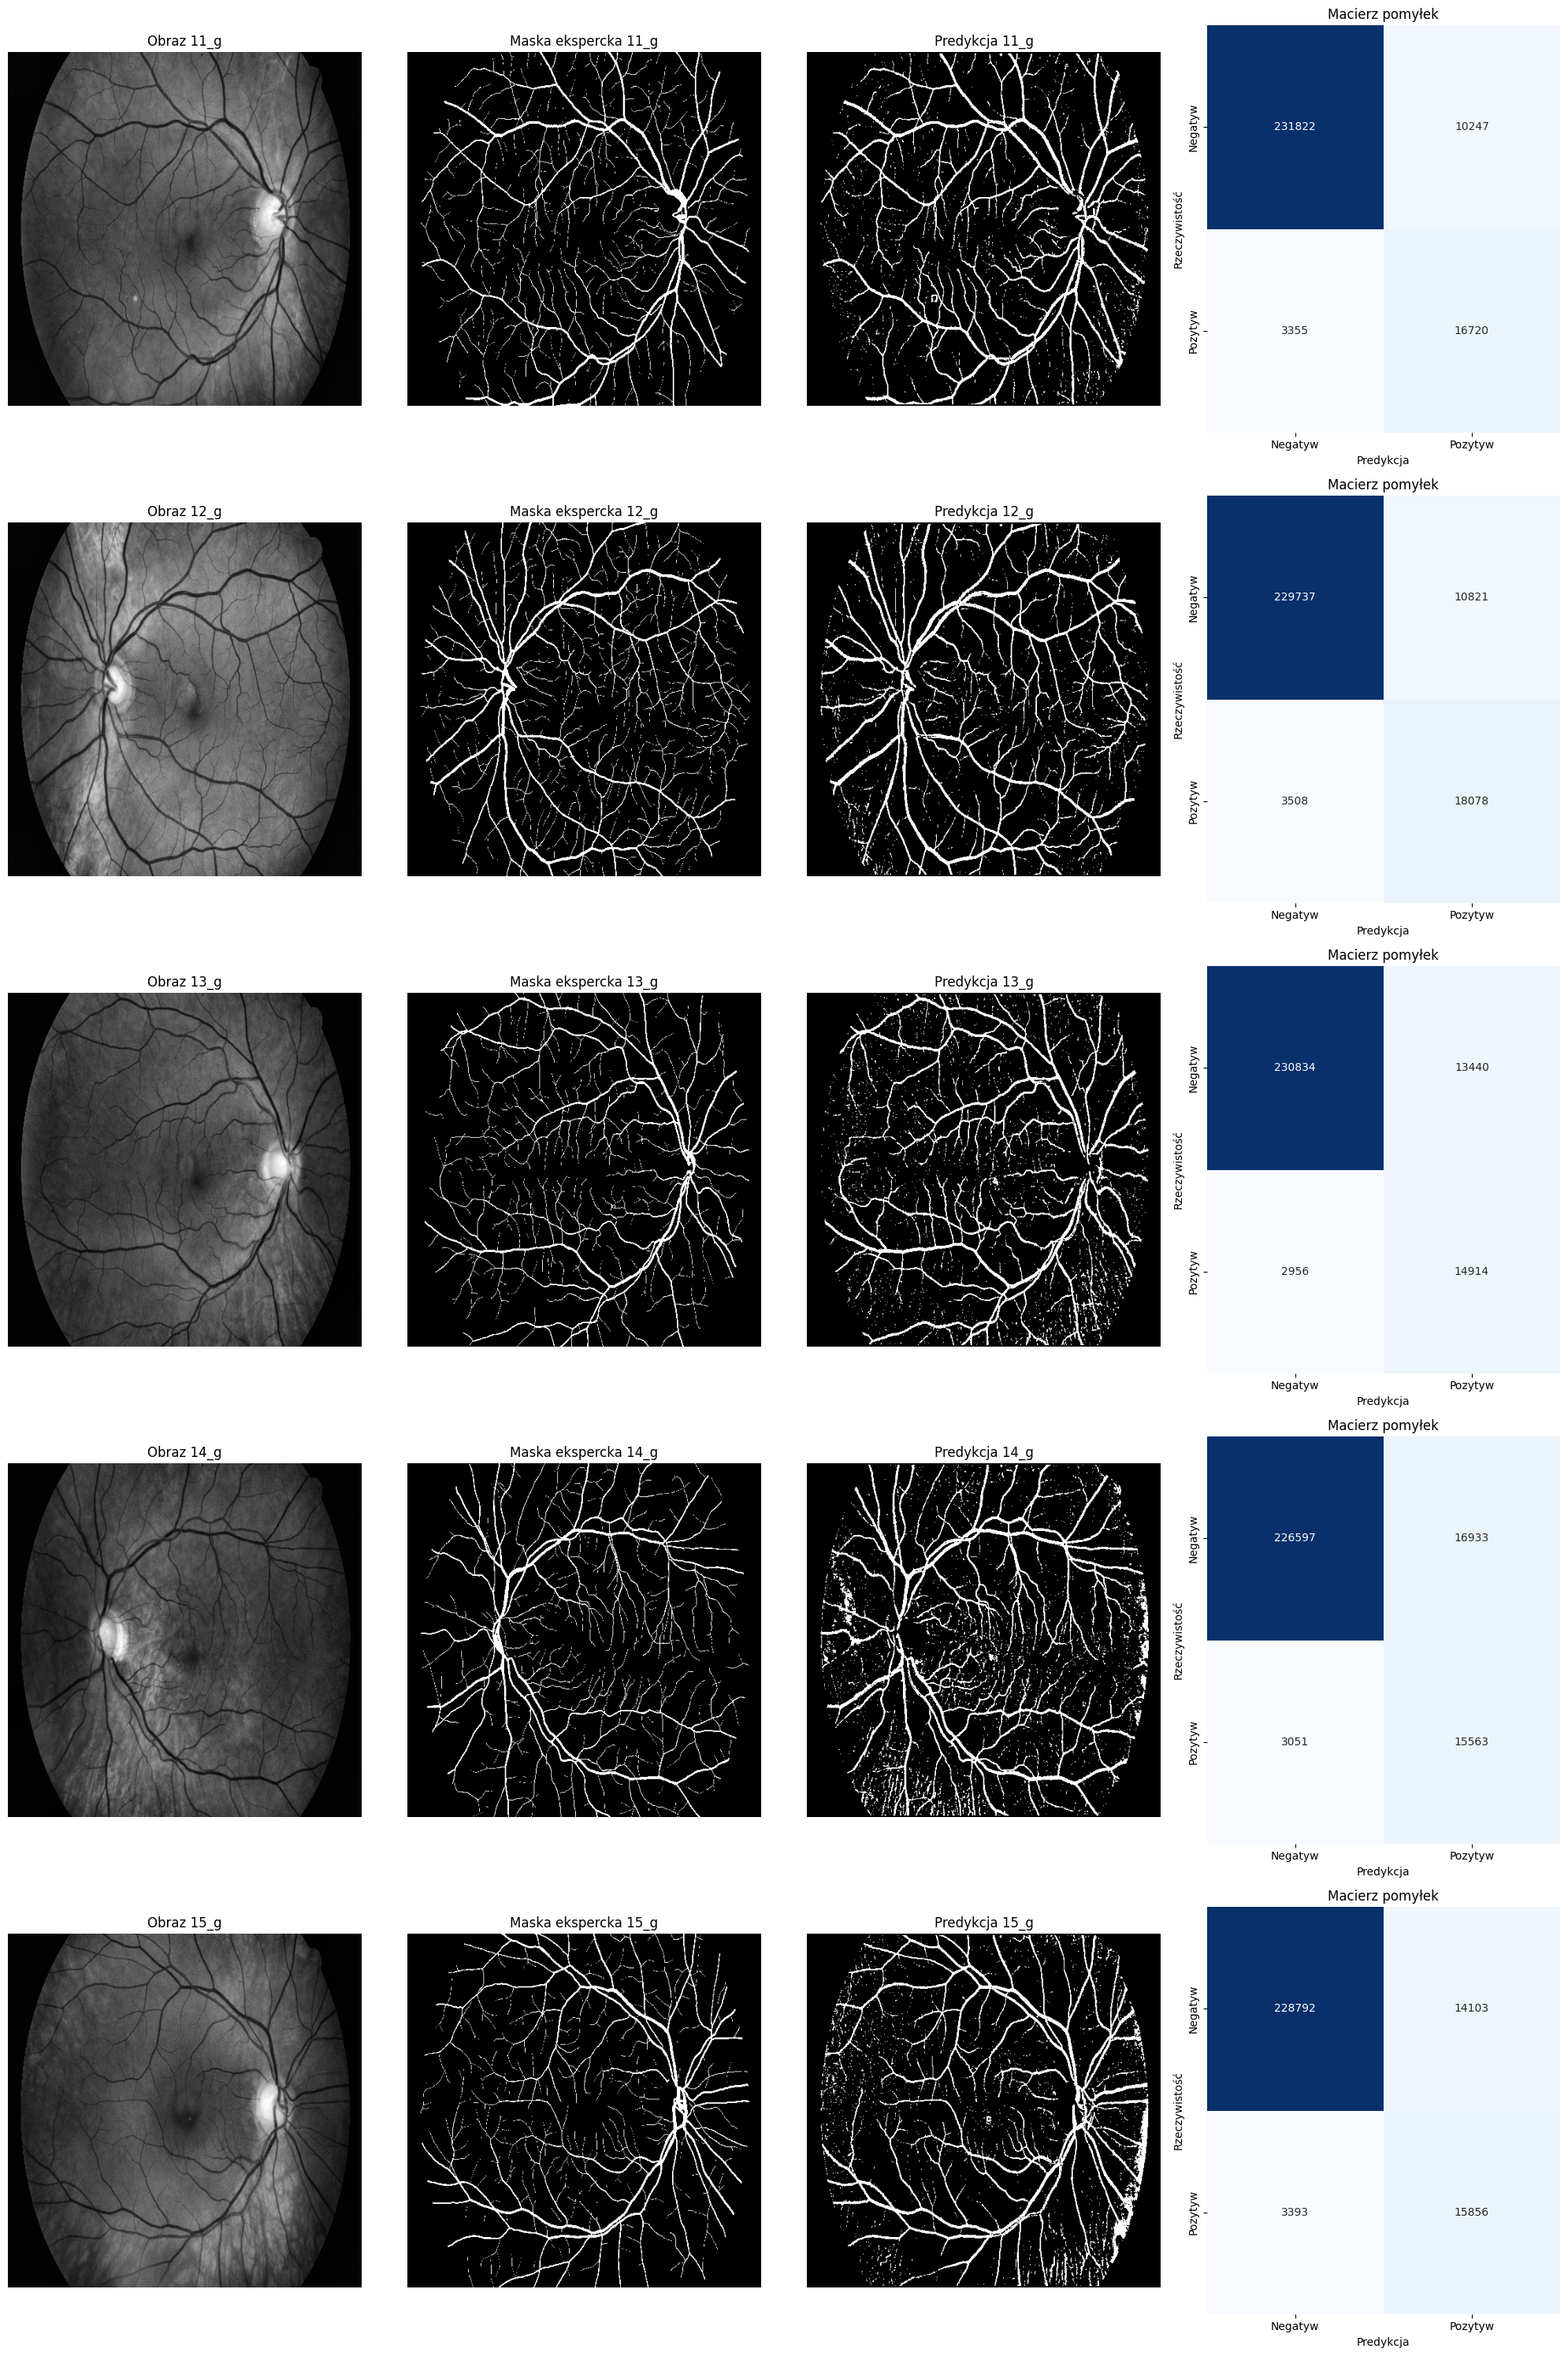

,Plik,Accuracy,Sensitivity,Specificity,Mean (arith),Mean (geom)
0,0,0.9481,0.8329,0.9577,0.8953,0.8931
1,1,0.9453,0.8375,0.9550,0.8963,0.8943
2,2,0.9375,0.8346,0.9450,0.8898,0.8881
3,3,0.9238,0.8361,0.9305,0.8833,0.8820
4,4,0.9333,0.8237,0.9419,0.8828,0.8809


In [ ]:

patch_size=5
plt.figure(figsize=(20, 30))
metrics_list = []

for idx, (img, mask) in enumerate(zip(processed_images, masks)):

    image_height, image_width = img.shape
    offset = patch_size // 2

    predicted_mask = np.zeros((image_height, image_width), dtype=np.uint8)

    patches = []
    positions = []

    step = 1

    for y in range(offset, image_height - offset, step):
        for x in range(offset, image_width - offset, step):
            patch = img[y - offset:y + offset + 1, x - offset:x + offset + 1]
            patches.append(patch.flatten())
            positions.append((y, x))

    patches = np.array(patches)

    print("Przetwarzam obraz ", idx)

    y_pred = grid_search.predict(patches)

    for (y, x), pred in zip(positions, y_pred):
        predicted_mask[y, x] = pred

    #Obliczamy metryki i macierz pomyłek
    accuracy, sensitivity, specificity, mean_arithmetic, mean_geometric, cm = show_parameters_from_masks(mask, predicted_mask)

    metrics_list.append({
        'Plik': idx,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Mean (arith)': mean_arithmetic,
        'Mean (geom)': mean_geometric
    })

    #Wyświetlanie obrazow
    plt.subplot(5, 4, 4*idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Obraz {image_names[idx]}')
    plt.axis('off')

    plt.subplot(5, 4, 4*idx + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Maska ekspercka {image_names[idx]}')
    plt.axis('off')

    plt.subplot(5, 4, 4*idx + 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f'Predykcja {image_names[idx]}')
    plt.axis('off')

    plt.subplot(5, 4, 4*idx + 4)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negatyw', 'Pozytyw'], yticklabels=['Negatyw', 'Pozytyw'])
    plt.title('Macierz pomyłek')
    plt.xlabel('Predykcja')
    plt.ylabel('Rzeczywistość')


plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame(metrics_list)

display(metrics_df.style
        .format({
            "Accuracy": "{:.4f}",
            "Sensitivity": "{:.4f}",
            "Specificity": "{:.4f}",
            "Mean (arith)": "{:.4f}",
            "Mean (geom)": "{:.4f}"
        })
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
        )